In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [3]:
def clear_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^ a-z]', '', text)
    while text.find('  ') != -1:
        text = text.replace('  ', ' ')
    return text

In [4]:
data_train['clean_text']= data_train['Text'].apply(lambda x:clear_text(x))
data_test['clean_text']= data_test['Text'].apply(lambda x:clear_text(x))

In [5]:
data_train['clean_text'] = data_train['clean_text'].apply(lambda x:word_tokenize(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:word_tokenize(x))

In [6]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    filtered_text = []
    for w in text:
        if w not in stop_words:
            filtered_text.append(w)
    return filtered_text

In [7]:
data_train['clean_text'] = data_train['clean_text'].apply(lambda x:remove_stop_words(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:remove_stop_words(x))

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(w) for w in text]

data_train['clean_text'] = data_train['clean_text'].apply(lambda x:lemmatizer(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:lemmatizer(x))

In [9]:
def to_text(data):
    text = []
    for i in data:
        for word in i:
            text.append(word)
    return text

text = to_text(data_train['clean_text'])
text += to_text(data_test['clean_text'])
text.sort()
dictionary = []
for i in text:
    if i not in dictionary:
        dictionary.append(i)


In [10]:
def convert_to_numbers(text):
    res = []
    for word in text:
        res.append(dictionary.index(word))
    return res

def convert_to_text(numbers):
    res = []
    for num in numbers:
        res.append(dictionary[num])
    return res

In [11]:
data_train['numbers'] = data_train['clean_text'].apply(lambda x:convert_to_numbers(x))
data_test['numbers'] = data_test['clean_text'].apply(lambda x:convert_to_numbers(x))

In [12]:
#good: happy, love, surprise
#bad: sadness, anger, fear

def t_or_f(emotion):
    if emotion == 'happy' or emotion == 'love' or emotion == 'surprise':
        return 1        
    else:        #elif emotioin == 'sadness' or 'anger' or 'fear': return 0
        return 0
    
data_train['Emotion_in_digit'] = data_train['Emotion'].apply(lambda x:t_or_f(x))
data_test['Emotion_in_digit'] = data_test['Emotion'].apply(lambda x:t_or_f(x))

# data_train[['Emotion','Emotion_in_digit']]

In [13]:
data_train = data_train[['Emotion_in_digit', 'numbers']]
data_test = data_test[['Emotion_in_digit', 'numbers']]

In [14]:
def vectorize_sequences(sequences, dimension=30000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [15]:
x_train = vectorize_sequences(data_train['numbers'])
x_test = vectorize_sequences(data_test['numbers'])

In [16]:
y_train = np.asarray(data_train['Emotion_in_digit']).astype("float32")
y_test = np.asarray(data_test['Emotion_in_digit']).astype("float32")

In [17]:
max_seq_len = 80
max_features = 30000

In [18]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_seq_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_seq_len)

In [19]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
max_seq_len = 80
max_features = 17123
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_seq_len)
emb_dim = 128

model = keras.Sequential()
model.add(layers.Embedding(max_features, emb_dim))
model.add(layers.LSTM(128))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [21]:
len(dictionary)

17123

In [22]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 512,
                    validation_split = 0.1, 
                    shuffle = True,
                    verbose = 1)

Epoch 1/10
29/29 [==============================] - 22s 685ms/step - loss: 0.6900 - accuracy: 0.5450 - val_loss: 0.6855 - val_accuracy: 0.5706
Epoch 2/10
29/29 [==============================] - 19s 662ms/step - loss: 0.6895 - accuracy: 0.5450 - val_loss: 0.6837 - val_accuracy: 0.5706
Epoch 3/10
29/29 [==============================] - 19s 665ms/step - loss: 0.6892 - accuracy: 0.5450 - val_loss: 0.6852 - val_accuracy: 0.5706
Epoch 4/10
29/29 [==============================] - 19s 661ms/step - loss: 0.6895 - accuracy: 0.5450 - val_loss: 0.6843 - val_accuracy: 0.5706
Epoch 5/10
29/29 [==============================] - 19s 663ms/step - loss: 0.6895 - accuracy: 0.5450 - val_loss: 0.6835 - val_accuracy: 0.5706
Epoch 6/10
29/29 [==============================] - 19s 663ms/step - loss: 0.6893 - accuracy: 0.5450 - val_loss: 0.6845 - val_accuracy: 0.5706
Epoch 7/10
29/29 [==============================] - 20s 678ms/step - loss: 0.6893 - accuracy: 0.5450 - val_loss: 0.6856 - val_accuracy: 0.5706

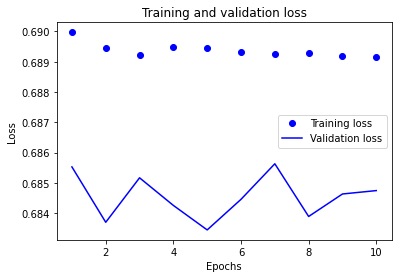

In [23]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2191744   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,323,457
Trainable params: 2,323,457
Non-trainable params: 0
_________________________________________________________________


In [25]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.6836960315704346
Test accuracy: 0.5768174529075623
